### JENA CLIMATE FOCASTING

In this notebook we are going to use the Jena Climate Dataset to build an `CNN` model that will predict weather. This notebook uses the previous notebook as reference. Few things will change from the previous notebook.

### Imports

In the following code cell we are going to import all the packages that we will be using in this notebook.

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torch.nn import functional as F
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from helperfns.tables import tabulate_data
from helperfns.utils import hms_string
from copy import deepcopy as dc
from sklearn.model_selection import train_test_split
from zipfile import ZipFile

print("Numpy: ", np.__version__)
print("Torch: ", torch.__version__)


Numpy:  1.26.4
Torch:  2.2.2


### Seed
Next we are going to set the seed to be `23` for reproducivity in this notebook.

In [2]:
SEED = 23
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deteministic = True

### Device
Next we are going to get the device to be `GPU` if we have GPU access.

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Loading data.

We are going to load the data from  the `jena_climate_2009_2016.csv` file into pandas dataframe.

In [4]:
dataframe = pd.read_csv('jena_climate_2009_2016.csv')
dataframe.head(2)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1


From our dataframe, if we look at the `Date Time` column we can see that the weather focus was in a `10minutes` interval. We want to make this to be an `hourly` interval so that our data will be a bit small.

In [5]:
dataframe = dataframe[5::6]
dataframe.head(2)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3


Then we want to make our `Date Time` an index column and change the format of our date time using the `to_datetime` function

In [6]:
dataframe.index = pd.to_datetime(dataframe['Date Time'], format='%d.%m.%Y %H:%M:%S')
dataframe.head(2)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,,
2009-01-01 01:00:00,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3


For now we are going to focus on predicting the Temperature in `deg C`.


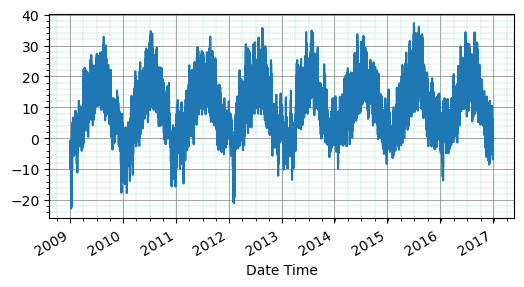

In [7]:
plt.figure(figsize=(6, 3))
temp = dataframe['T (degC)']
temp.plot()

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.show()

From the data that we have just ploted we can see that there is a pattern in this data. Surely during the year the lower temperatures indicates `winter` temperatures that was recorded.

So we are going to predict temperature based on the previously recorded temperatures. We are going to set the default ``window_size``  to be 5. This means that we will use the previous 5 values to get the current value.

In [8]:
def dataframe_to_X_y(dataframe, window_size=5):
    values = dataframe.to_numpy()
    X = []
    y = []
    for i in range(len(values) - window_size):
        row = [[a] for a in values[i:i+window_size]]
        label = values[i+window_size]
        X.append(row)
        y.append([label])
    return np.array(X), np.array(y)
X, y = dataframe_to_X_y(temp)
X.shape, y.shape

((70086, 5, 1), (70086, 1))

Next we are going to split our data into 3 subsets, which are

1. train
2. test
2. valid

In [9]:
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.10, shuffle=False) ## this is a time series prediction
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, shuffle=False) ## this is a time series prediction

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((56769, 5, 1), (56769, 1), (7009, 5, 1), (7009, 1), (6308, 5, 1), (6308, 1))

Next we are going to check the examples that are in each set using a table.

In [10]:
columns = ["Set", "Total"]
_data = [
    ["TRAINING", f"{len(X_train):,}"],
    ["TESTING", f"{len(X_test):,}"],
    ["VALIDATION", f"{len(X_val):,}"],
    ["TOTAL", f"{len(X_train) + len(X_test) + len(X_val):,}"],
]
tabulate_data(columns, _data, title="SETS EXAMPLES")

SETS EXAMPLES
+------------+--------+
| Set        |  Total |
+------------+--------+
| TRAINING   | 56,769 |
| TESTING    |  7,009 |
| VALIDATION |  6,308 |
| TOTAL      | 70,086 |
+------------+--------+


Next we want to convert our features and labels to pytorch long tensors.

In [11]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

X_val = torch.from_numpy(X_val).float()
y_val = torch.tensor(y_val).float()

### Dataset

Next we are going to create a `ClimateFocastingDataset`, this will take the features and labels and we will use this one to batch our data before training

In [12]:
class ClimateFocastingDataset(Dataset):
    def __init__(self, X, y):
        super(ClimateFocastingDataset, self).__init__()
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.y[index], self.X[index]

Let's create the dataset for each set.

In [13]:
train_dataset = ClimateFocastingDataset(X_train, y_train)
test_dataset = ClimateFocastingDataset(X_test, y_test)
val_dataset = ClimateFocastingDataset(X_val, y_val)

Next we are going to batch our data, we are going to set the batchsize to be `64`. We are going to turn on the shuffle of the train dataset only.

In [14]:
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Let's check a single example in the first batch, in the training dataset

In [15]:
for batch in train_loader:break

In [16]:
batch[0][:3]

tensor([[ 3.6600],
        [17.0300],
        [19.6200]])

In [17]:
batch[1][0]

tensor([[4.1200],
        [4.0300],
        [3.8600],
        [3.8400],
        [3.7700]])

### Model

Next thing we want to build an ``CNN`` model that will train on this data.

> For this we are going to use the `Conv1D` layer.

In [18]:

class ClimateFocastingCNN(nn.Module):
    def __init__(self, 
                 input_size,
                 hidden_size,
                 filter_sizes,
                 output_size, 
                 dropout=0.5
                ):
        super(ClimateFocastingCNN, self).__init__()
        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=input_size,
                out_channels = hidden_size,
                kernel_size=fs
            ) for fs in filter_sizes 
        ])
        self.out = nn.Sequential(
            nn.Linear(len(filter_sizes) * hidden_size, 8),
            nn.ReLU(inplace=False),
            nn.Linear(8, output_size),
        )
        self.dropout = nn.Dropout(dropout/3)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        conved = [F.relu(conv(x)) for conv in self.convs]
        pooled = [
            F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved
        ]
        cat = self.dropout(torch.cat(pooled, dim=1))
        out = self.out(cat)
        return out
        
INPUT_DIM = 1
HIDDEN_DIM = 64
OUTPUT_DIM = 1 
DROPOUT = 0.75
FILTER_SIZES = [3, 3, 5, 5]

model_1 = ClimateFocastingCNN(
    INPUT_DIM, HIDDEN_DIM, 
    FILTER_SIZES,
    OUTPUT_DIM, 
    dropout = DROPOUT
).to(device)
model_1

ClimateFocastingCNN(
  (convs): ModuleList(
    (0-1): 2 x Conv1d(1, 64, kernel_size=(3,), stride=(1,))
    (2-3): 2 x Conv1d(1, 64, kernel_size=(5,), stride=(1,))
  )
  (out): Sequential(
    (0): Linear(in_features=256, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.25, inplace=False)
)

Next we are going to count the model parameters.

In [19]:
def count_trainable_params(model):
  return f"{sum(p.numel() for p in model.parameters()):,}", f"{sum(p.numel() for p in model.parameters() if p.requires_grad):,}"

columns = ["MODEL", "TOTAL PARAMS", "TRAINABLE PARAMS"]
data = [
    ["model", *count_trainable_params(model_1)],
]
tabulate_data(columns, data, title="Models Parameters")

Models Parameters
+-------+--------------+------------------+
| MODEL | TOTAL PARAMS | TRAINABLE PARAMS |
+-------+--------------+------------------+
| model |        3,345 |            3,345 |
+-------+--------------+------------------+


Next we are going to create the `optimizer` and `loss` function. For the loss function i will use the `MSELoss` and for the optmizer i will use the `Adam`.

In [20]:
optimizer = torch.optim.Adam(model_1.parameters())
criterion = nn.MSELoss().to(device)

Next we are going to define our train and evaluate functions. 

1. `train`
- Keep in track of the avarage `mse` loss per epoch
- Put the model in train mode
- Zero the gradients
- Make prediction
- Calculate the loss
- Update the weights

2. `evaluate`
- We don't need to compute the gradients
- Keep in track of the avarage `mse` loss per epoch
- Put the model in train mode
- Make prediction
- Calculate the loss

In [21]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    model.train(True)
    for y, X in iterator:
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        predictions = model(X)
        loss = criterion(predictions, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
  epoch_loss =  0
  model.eval()
  with torch.no_grad():
    for y, X in iterator:
      X = X.to(device)
      y = y.to(device)
      predictions = model(X)
      loss = criterion(predictions, y)
      epoch_loss += loss.item()
  return epoch_loss / len(iterator)

### Training Loop.
When training the model. And we are also going to keep on tracking the training history of each model. The following History class is a data structure for our training history.

In [22]:
class History:
    def __init__(self):
        self.train_losses = list()
        self.epoch_train_time = list()
        self.val_losses = list()
    def add(self, train_loss:float, val_loss:float, elt:float):
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.epoch_train_time.append(elt)

We are going to train the model for `10` epochs.

In [23]:
def run_train_loop(model, model_name, train_loader, val_loader,  epochs=20, optimizer=None, criterion=None):
  best_valid_loss = float('inf')
  last_saved_epoch = 1
  history = History()
  training_start = time.time()
  for epoch in range(epochs):
    start = time.time()
    train_loss = train(model, train_loader, optimizer, criterion)
    valid_loss = evaluate(model, val_loader, criterion)
    title = f"EPOCH: {epoch+1:02}/{epochs:02} {'saving best model...' if valid_loss < best_valid_loss else 'not saving...'}"
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_name)
        last_saved_epoch = epoch+1
    end = time.time()
    history.add(train_loss, valid_loss, end-start)
    data = [
        ["Training", f'{train_loss:.3f}',  f"{hms_string(end - start)}" ],
        ["Validation", f'{valid_loss:.3f}',  "" ],
    ]
    columns = ["CATEGORY", "LOSS (mse)", "ETA"]
    tabulate_data(columns, data, title)

  training_end = time.time()
  return history, training_end - training_start, last_saved_epoch

In [24]:
EPOCHS = 10
history, elt, last_saved_epoch = run_train_loop(
    model_1, 'cnn-model-1.pt', train_loader, val_loader, EPOCHS,
    optimizer=optimizer, criterion=criterion
)

EPOCH: 01/10 saving best model...
+------------+------------+------------+
| CATEGORY   | LOSS (mse) |        ETA |
+------------+------------+------------+
| Training   |      3.007 | 0:02:30.67 |
| Validation |      0.665 |            |
+------------+------------+------------+
EPOCH: 02/10 saving best model...
+------------+------------+------------+
| CATEGORY   | LOSS (mse) |        ETA |
+------------+------------+------------+
| Training   |      1.235 | 0:01:26.66 |
| Validation |      0.649 |            |
+------------+------------+------------+
EPOCH: 03/10 not saving...
+------------+------------+------------+
| CATEGORY   | LOSS (mse) |        ETA |
+------------+------------+------------+
| Training   |      1.178 | 0:01:39.65 |
| Validation |      0.973 |            |
+------------+------------+------------+
EPOCH: 04/10 not saving...
+------------+------------+------------+
| CATEGORY   | LOSS (mse) |        ETA |
+------------+------------+------------+
| Training   |   

Let's visualize the training history.

In [25]:
rows = [
      ["TOTAL EPOCHS", f'{EPOCHS}'],
      ["LAST SAVED EPOCH", f'{last_saved_epoch}'],
      ["TOTAL TRAINING TIME", f'{hms_string(elt)}']
]
tabulate_data(['', 'value'], rows, "MODEL TOTAL TRAINING TIME AND LAST SAVED EPOCH")

MODEL TOTAL TRAINING TIME AND LAST SAVED EPOCH
+---------------------+------------+
|                     |      value |
+---------------------+------------+
| TOTAL EPOCHS        |         10 |
| LAST SAVED EPOCH    |          7 |
| TOTAL TRAINING TIME | 0:21:47.02 |
+---------------------+------------+


Let's check how long the model took to train each epoch.

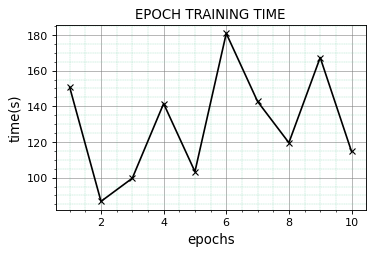

In [26]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.epoch_train_time, "x-", color='k', label='ett')
plt.title("EPOCH TRAINING TIME", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("time(s)", fontsize=12)

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

Let's visialize the training and validation losses that was observed during training the model.

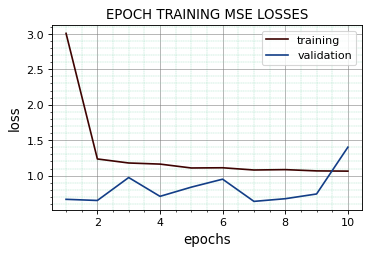

In [27]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.train_losses, color='#3D0301', label='training')
plt.plot(epochs, history.val_losses, color='#133E87', label='validation')
plt.title("EPOCH TRAINING MSE LOSSES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("loss", fontsize=12)

plt.legend(fontsize=10)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

In the next code cell we are going to evaluate our best model on the test data using the `MSE`.

In [28]:
model_1.load_state_dict(torch.load('cnn-model-1.pt'))
test_loss = evaluate(model_1, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f}')

Test Loss: 0.645


Let's make some predictions based on our data.

In [29]:
def predict(X, device):
    with torch.no_grad():
        predicted = model_1(X.to(device)).to('cpu').numpy()
    return predicted
predicted = predict(X_train, device)

Let's check the predictions in the training data. We are going to plot the first `100` temperature predictions.

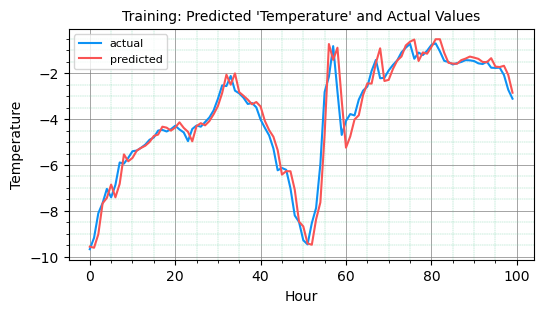

,actuals,predicted
0,-9.67,-9.556376
1,-9.17,-9.605765
2,-8.10,-9.015777
3,-7.66,-7.671589
4,-7.04,-7.432494
5,-7.41,-6.852497
6,-6.87,-7.408933
7,-5.89,-6.821781
8,-5.94,-5.537402
9,-5.69,-5.838496


In [30]:
train_true = y_train.flatten().numpy()[:100]
train_preds = predicted.flatten()[:100]

plt.figure(figsize=(6, 3))
plt.plot(train_true, label='actual', color="#0D92F4")
plt.plot(train_preds, label='predicted', color="#F95454")
plt.xlabel('Hour', fontsize=10)
plt.ylabel('Temperature', fontsize=10)

plt.legend(fontsize=8)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.title("Training: Predicted 'Temperature' and Actual Values", fontsize=10)
plt.show()

train_preds_dataframe = pd.DataFrame({ "actuals": train_true , "predicted": train_preds})
train_preds_dataframe.head(10)

Let's check the predictions in the validation data. We are going to plot the first `100` temperature predictions.

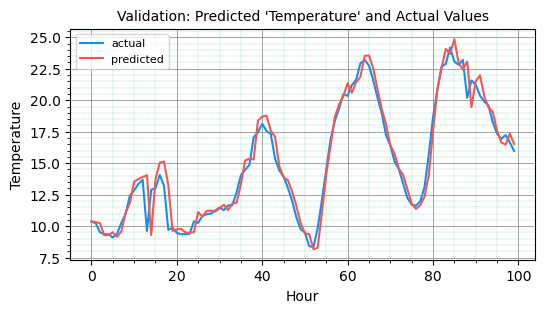

,actuals,predicted
0,10.35,10.368151
1,10.24,10.315764
2,9.51,10.233596
3,9.36,9.268686
4,9.35,9.296846
5,9.10,9.511586
6,9.39,9.153577
7,10.25,9.566695
8,10.95,11.054783
9,12.41,11.841228


In [31]:
predicted = predict(X_val, device)

val_true = y_val.flatten().numpy()[:100]
val_preds = predicted.flatten()[:100]

plt.figure(figsize=(6, 3))
plt.plot(val_true, label='actual', color="#0D92F4")
plt.plot(val_preds, label='predicted', color="#F95454")
plt.xlabel('Hour', fontsize=10)
plt.ylabel('Temperature', fontsize=10)

plt.legend(fontsize=8)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.title("Validation: Predicted 'Temperature' and Actual Values", fontsize=10)
plt.show()

val_preds_dataframe = pd.DataFrame({ "actuals": val_true , "predicted": val_preds})
val_preds_dataframe.head(10)

Let's check the predictions in the testing data. We are going to plot the first `150` temperature predictions.

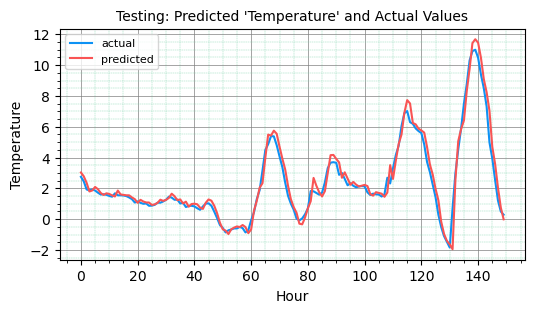

,actuals,predicted
0,2.75,3.031421
1,2.46,2.785671
2,1.93,2.364747
3,1.87,1.799515
4,1.93,1.864883
5,1.86,2.092978
6,1.72,1.945679
7,1.60,1.700282
8,1.62,1.573401
9,1.58,1.680838


In [32]:

predicted = predict(X_test, device)

test_true = y_test.flatten().numpy()[:150]
test_preds = predicted.flatten()[:150]

plt.figure(figsize=(6, 3))
plt.plot(test_true, label='actual', color="#0D92F4")
plt.plot(test_preds, label='predicted', color="#F95454")
plt.xlabel('Hour', fontsize=10)
plt.ylabel('Temperature', fontsize=10)

plt.legend(fontsize=8)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.title("Testing: Predicted 'Temperature' and Actual Values", fontsize=10)
plt.show()

test_preds_dataframe = pd.DataFrame({ "actuals": test_true , "predicted": test_preds})
test_preds_dataframe.head(10)


Next we are going to implement the `Multivariate Time Series Forecasting Using LSTM`.